## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Настройки отображения графиков
%matplotlib inline
# Стили графиков 
sns.set_style("whitegrid")
font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

# 1) Стоит ли нам оставить старый вариант работы или заменить на новый?

In [2]:
#Подгружаем наш датасет
df = pd.read_csv('ab_test_ensembles.csv')

In [3]:
# Убедимся, что контрольная испытуемая группы видят разные работы сервиса
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [4]:
# Провери уникальность пользователей
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [5]:
# Вычисляем долю уникальных значений относительно общего числа вхождений
df.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

### Визуализация результатов

In [6]:
conversion_rates = df.groupby('group')['converted']

# Стандартное отклонение выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.89% против ~12.04%

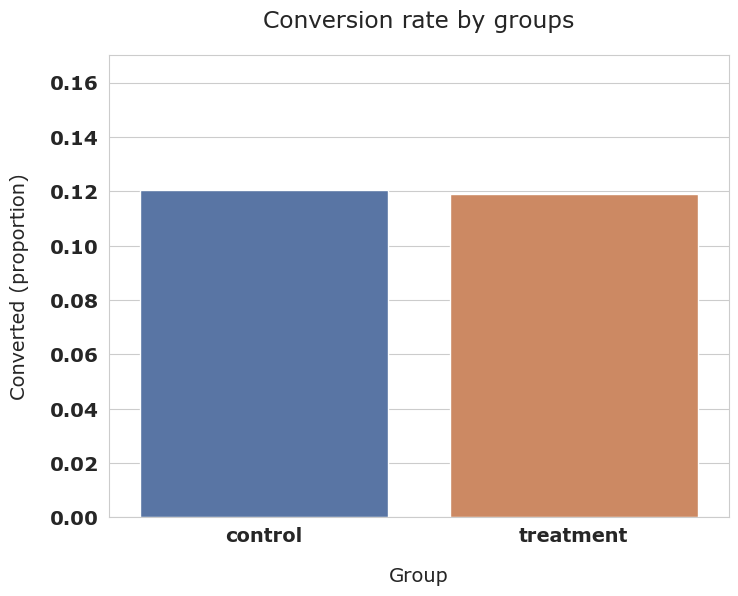

In [7]:
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='converted', data=df, hue='group', errorbar=('ci', False), palette="deep", legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by groups', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()

 Тестирование гипотезы

In [8]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


### Интерпретация результатов 

Так как наше p-значение = 0.216 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, это означает, что новый вариант работы svm_ensemble_v_1_22 никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.117, 0.121] или 11% и 12% соответственно:

Он не включает наш baseline в 13%.
Он не достигает нашей цели 15%
Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии нового варианта будет близок к baseline чем к 15%, который мы определили по нашей цели. 

Таким образом у нас есть выбор:
1. Так как мы будем близко к baseline то можно оставить этот вариант работы.
2. Можно создать новый вариант (потратить время, деньги, нервы) и опять протестировать, необходимо решить стоит ли 'напрягатся' ради улучшения на 2% (окупятся ли затраты на работу).
3. Ничего не менять.

# 2) Cтоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы

Чтобы ответить на поставленный вопрос, проведем два А\B теста, для групп registered user и new user

### Тест для группы registered user

In [9]:
# Создадим датасет с registered user
reg_us_df = df.loc[df['user_type'] == 'registered_user']

In [10]:
# Проверим уникальность пользователей
sessions = reg_us_df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [11]:
# Вычисляем долю уникальных значений относительно общего числа вхождений
reg_us_df.variants.value_counts(normalize=True)

variants
svm_ensemble_v_1_22    0.501209
standard               0.498791
Name: proportion, dtype: float64

In [12]:
# рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки
conversion_rates = reg_us_df.groupby('variants')['converted']

# Стандартное отклонение для выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
variants,,,
standard,0.119877,0.324818,0.001199
svm_ensemble_v_1_22,0.120450,0.325488,0.001198


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, в том числе выборочные средние коэффициенты конверсии ~11.98% для старого варианта работы и ~12.04% для нового варианта

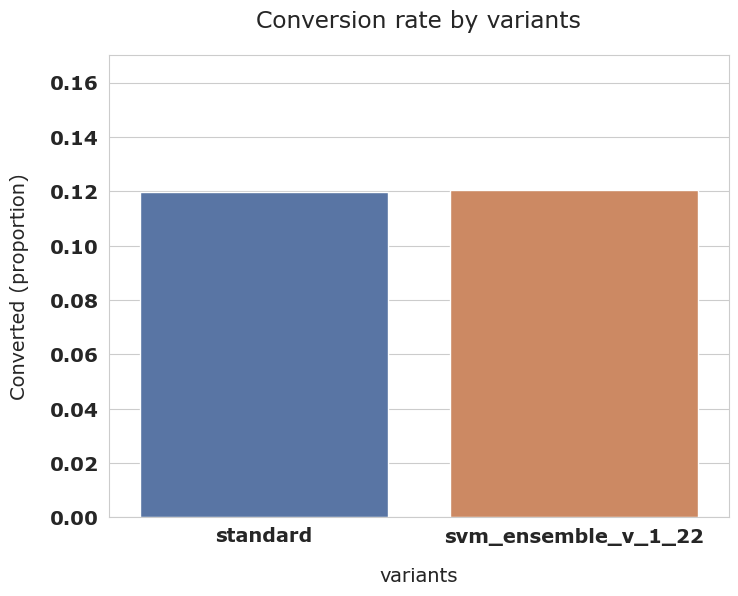

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x='variants', y='converted', data=reg_us_df, hue='variants', errorbar=('ci', False), palette="deep", legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by variants', pad=20)
plt.xlabel('variants', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()

### Тестирование гипотезы для группы registered_user

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

standard_res = reg_us_df[reg_us_df['variants'] == 'standard']['converted']
svm_res = reg_us_df[reg_us_df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_standard = standard_res.count()
n_svm = svm_res.count()
successes = [standard_res.sum(), svm_res.sum()]
nobs = [n_standard, n_svm]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_new, lower_registered), (upper_new, upper_registered) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for standard: [{lower_new:.3f}, {upper_new:.3f}]')
print(f'CI 95% for svm_ensemble_v_1_22: [{lower_registered:.3f}, {upper_registered:.3f}]')

Z-statistic: -0.34
p-value: 0.735
CI 95% for standard: [0.118, 0.122]
CI 95% for svm_ensemble_v_1_22: [0.118, 0.123]


Так как наше p-значение = 0.216 что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, это означает, что новый вариант никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.117, 0.121] или 11% и 12% соответственно:
1. Он не включает наш baseline в 13%.
2. Он не достигает нашей цели 15%

Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии нового варианта будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас есть выбор:
1. Так как мы будем близко к baseline то можно оставить этот вариант работы.
2. Можно создать новый вариант (потратить время, деньги, нервы) и опять протестировать, необходимо решить стоит ли 'напрягатся' ради улучшения на 2% (окупятся ли затраты на работу).
3. Ничего не менять.

### Тест для группы new user

In [15]:
# Создадим датасет с new user
new_us_df = df.loc[df['user_type'] == 'new_user']

In [16]:
# Проверим уникальность пользователей
sessions = new_us_df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [17]:
# Вычисляем долю уникальных значений относительно общего числа вхождений
new_us_df.variants.value_counts(normalize=True)

variants
standard               0.501209
svm_ensemble_v_1_22    0.498791
Name: proportion, dtype: float64

In [18]:
# рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки
conversion_rates = new_us_df.groupby('variants')['converted']

# Стандартное отклонение для выборки
std_proportion = lambda x: np.std(x, ddof=0)

# Стандартная ошибка для выборки
se_proportion = lambda x: stats.sem(x, ddof=0)

# уровень коверсии
conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
variants,,,
standard,0.121075,0.326215,0.001201
svm_ensemble_v_1_22,0.117223,0.321686,0.001187


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.7% для нового варианта работы против ~12.1% для старого варианта 

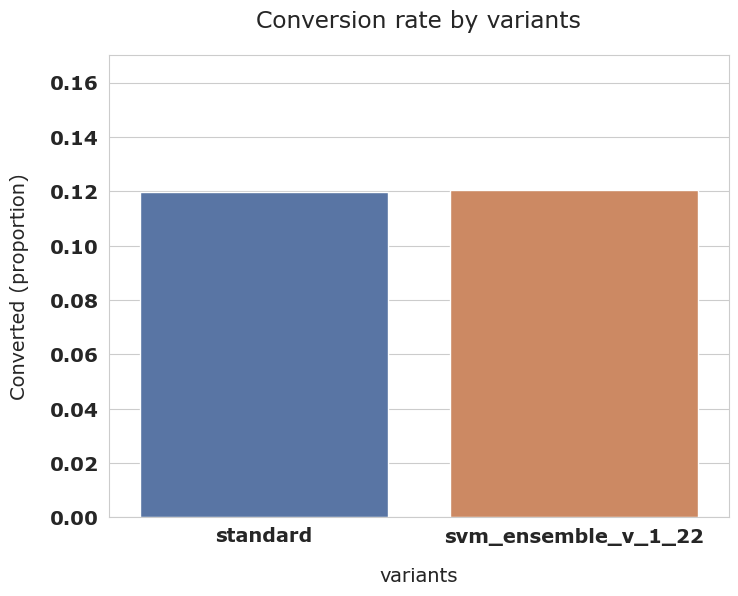

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x='variants', y='converted', data=reg_us_df, hue='variants', errorbar=('ci', False), palette="deep", legend=False) 
plt.ylim(0, 0.17)
plt.title('Conversion rate by variants', pad=20)
plt.xlabel('variants', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()

### Тестирование гипотезы для группы new user

In [20]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

standard_res = new_us_df[new_us_df['variants'] == 'standard']['converted']
svm_res = new_us_df[new_us_df['variants'] == 'svm_ensemble_v_1_22']['converted']

n_standard = standard_res.count()
n_svm = svm_res.count()
successes = [standard_res.sum(), svm_res.sum()]
nobs = [n_standard, n_svm]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_new, lower_registered), (upper_new, upper_registered) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for standard: [{lower_new:.3f}, {upper_new:.3f}]')
print(f'CI 95% for svm_ensemble_v_1_22: [{lower_registered:.3f}, {upper_registered:.3f}]')

Z-statistic: 2.28
p-value: 0.023
CI 95% for standard: [0.119, 0.123]
CI 95% for svm_ensemble_v_1_22: [0.115, 0.120]


Так как наше p-значение = 0.023 что ниже выбранной альфы 0.05, то согласно статистическому выводу, мы можем отклонить нулевую гипотезу H0. Это значит, что новый вариант работы статистически значимо влияет на уровень конверсии и повышение уровня конверсии в отношении новых пользоватлей.

Доверительный интервал для испытуемой группы [0.115, 0.120] или 11% и 12% соответственно:
1. Он не включает наш baseline в 13%
2. Он не достигает нашей цели 15%

Новый вариант работы статистически влияет на новых пользователей, но не достигает нашей цели по увеличению конверсии на 2%.
Таким образом у нас есть выбор:
1. Новый вариант работы влияет на новых пользователей, поэтому есть смысл дорабоать новый вариант и снова оценить             
2. Можем оставить старый вариант работы, если доработка не окупится

# EDA

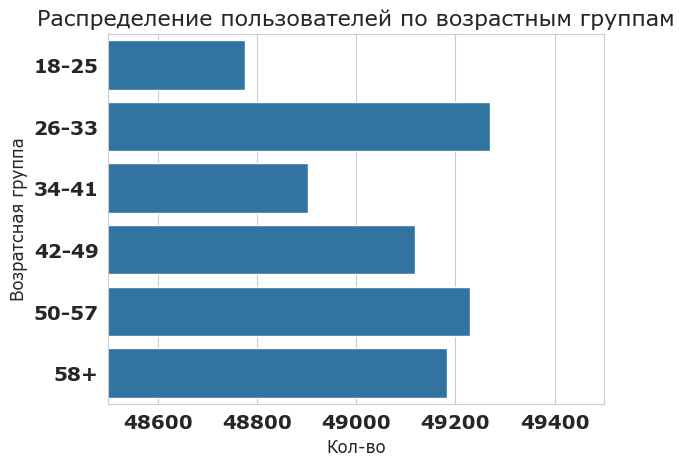

In [21]:
#подготовка данных
df_age = df.groupby('age_group').size().reset_index().rename(columns={0: "count"})

# создадим барчарт
sns.barplot(x='count', y='age_group', data=df_age, legend=False, orient='h')

# добавим подписи осей
plt.title('Раcпределение пользователей по возрастным группам', fontsize=16)
plt.xlabel('Кол-во', fontsize=12)
plt.ylabel('Возратсная группа', fontsize=12)
plt.xlim(48500, 49500)

# вывод графика
plt.show()

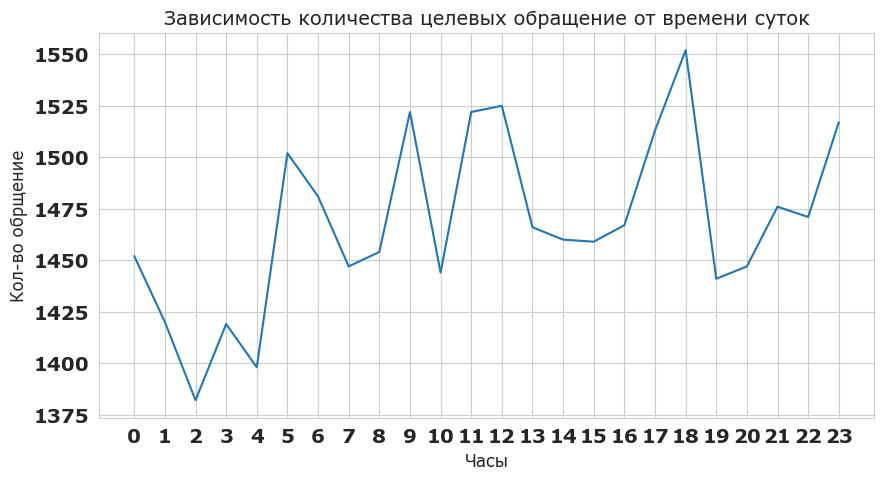

In [22]:
df_hours_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.hour)['converted'].sum().reset_index().rename(columns={"converted": "count"})

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_hours_activity, x='timestamp', y='count')

plt.xticks(ticks=np.arange(0, 24, 1))

plt.title('Зависимость количества целевых обращение от времени суток', fontsize=14)
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Кол-во обрщение', fontsize=12)

plt.show()